# Covid-19 and Socioeconomic factors
## David Mendez - 2031825 
## Jose Hernandez - 2139856 
## Jessica Sanchez - 2188533

1. EDA, because it is the foundation of our data analysis, we need to understand the data, its 
distribution, and the relationship between the different variables and patterns, as well it help us 
identify data issues (e.g. missing values)

2. Outlier detection once EDA 
is completed, where it is crucial to identify and handle outliers before building any model 
because it can affect its performance

3.  the classification that will 
categorize regions based on risk levels (low, medium, high)

4. all members will participate 
in the regression analysis to predict the total number of deaths, because it requires a solid 
understanding of the relationships between independent (e.g. socioeconomic) and dependent 
(total deaths) variables, which have been obtained in the EDA and classification tasks.

# Task 1: EDA and outlier detection.
During our first task our goal was to observe how each varible interact with the others, to observe tendencies; the variables used in this project are: 'total_cases', 'total_deaths', 'gdp_per_capita', 'life_expectancy','population_density', 'stringency_index', 'median_age', 'hospital_beds_per_thousand', 'human_development_index', 'extreme_poverty', 'location', 'continent', 'date'.
Before creating/using any variable, we dealt with absecence of data, where our approach was to remove the rows that had 50% or more values missing.
After succesfully preprosessing the data of the variables we will be working on creating different visualizations of the variables and their relationships.

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_circles
from sklearn.cluster import DBSCAN
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [15]:
sub = pd.read_csv('owid_covid_data.csv')
sub['date'] = pd.to_datetime(sub['date'])
mask = (sub['date'] >= '2020-04-01') & (sub['date'] <= '2023-04-30')
df_filtered = sub[mask].copy()


#Keep only necessary columns
keep = [
    'location', 'continent', 'date',
    'total_cases', 'total_deaths',
    'gdp_per_capita', 'life_expectancy', 'population_density',
    'stringency_index', 'median_age',
    'hospital_beds_per_thousand', 'human_development_index', 'extreme_poverty',
    'new_cases'
]
df_filtered = df_filtered[keep]

df_nonzero_cases = df_filtered[df_filtered['new_cases'] > 0].copy()

df_nonzero_cases = df_nonzero_cases.drop(columns=['new_cases'])

sub = df_nonzero_cases.sort_values(by=['location', 'date']).reset_index(drop=True)
sub = sub.dropna()

numerical_cols = [
    'total_cases', 'total_deaths', 'gdp_per_capita', 'life_expectancy',
    'population_density', 'stringency_index', 'median_age',
    'hospital_beds_per_thousand', 'human_development_index', 'extreme_poverty'
]

scaler = StandardScaler()
sub_scaled_numerical = pd.DataFrame(scaler.fit_transform(sub[numerical_cols]), columns=numerical_cols)

sub_scaled = pd.concat([sub[['location', 'continent', 'date']].reset_index(drop=True), sub_scaled_numerical], axis=1)

print(sub_scaled.head())

  location continent       date  total_cases  total_deaths  gdp_per_capita  \
0  Albania    Europe 2020-04-05    -0.297351     -0.338866       -0.351407   
1  Albania    Europe 2020-04-12    -0.297336     -0.338808       -0.351407   
2  Albania    Europe 2020-04-19    -0.297319     -0.338779       -0.351407   
3  Albania    Europe 2020-04-26    -0.297300     -0.338770       -0.351407   
4  Albania    Europe 2020-05-03    -0.297286     -0.338731       -0.351407   

   life_expectancy  population_density  stringency_index  median_age  \
0         0.738589           -0.164429          1.588105    0.743426   
1         0.738589           -0.164429          1.588105    0.743426   
2         0.738589           -0.164429          1.823255    0.743426   
3         0.738589           -0.164429          1.823255    0.743426   
4         0.738589           -0.164429          1.823255    0.743426   

   hospital_beds_per_thousand  human_development_index  extreme_poverty  
0                    0.0

Data has been preprocessed. Now we will show the relationship of GDP per capita vs total death, and life expectancy vs total deaths.
'sub': initial cleaned dataset, includes 10 variables, handles missing values, and is raw data. We use it in EDA, to understand relationships (plots scatterplot, box plots, etc.)

'sub_scaled': cleaned and normalized data set, usig the same 10 variables but standardized (mean=0, std=1), and will add a risk_level label. We use for machine learning (classification), models perform better, and ensures all features contribute equally.

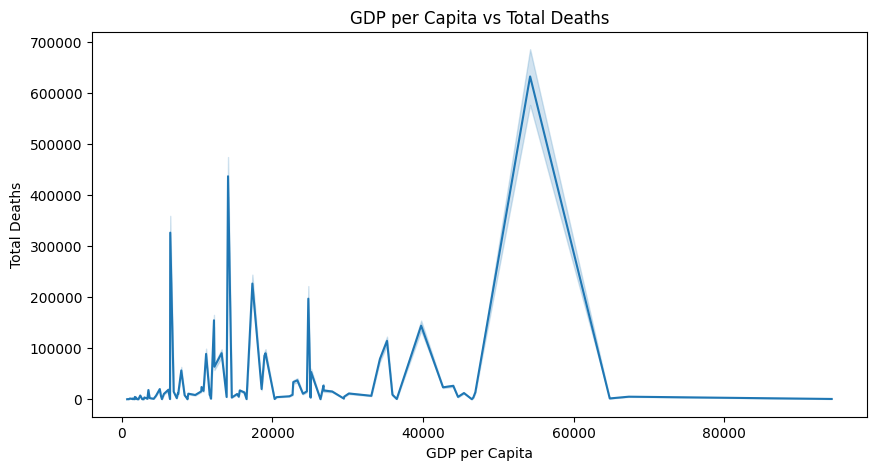

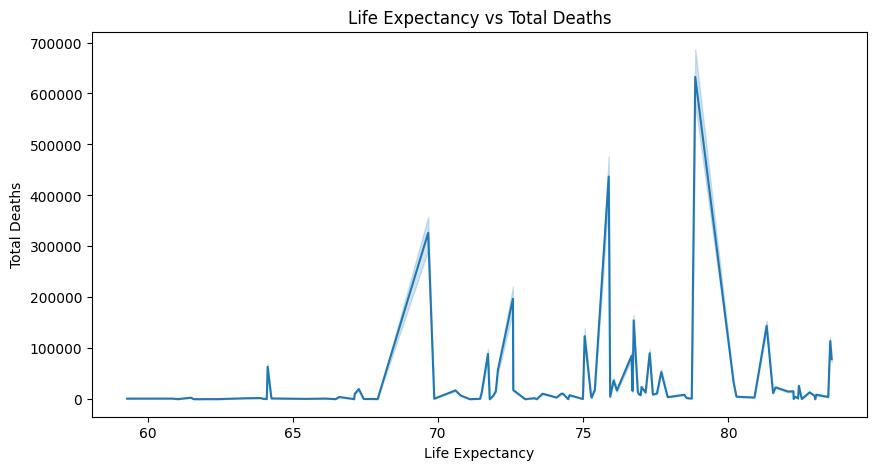

In [16]:
#lineplot for gdp vs total of deaths (not normalized)
plt.figure(figsize=(10, 5)) 
sns.lineplot(data= sub, x = 'gdp_per_capita', y = 'total_deaths')
plt.title('GDP per Capita vs Total Deaths')
plt.xlabel('GDP per Capita')
plt.ylabel('Total Deaths')
plt.show()

#lineplot for life expectancy vs total of deaths
plt.figure(figsize=(10, 5)) 
sns.lineplot(data= sub, x = 'life_expectancy', y = 'total_deaths')
plt.title('Life Expectancy vs Total Deaths')
plt.xlabel('Life Expectancy')
plt.ylabel('Total Deaths')
plt.show()

<Figure size 1000x800 with 0 Axes>

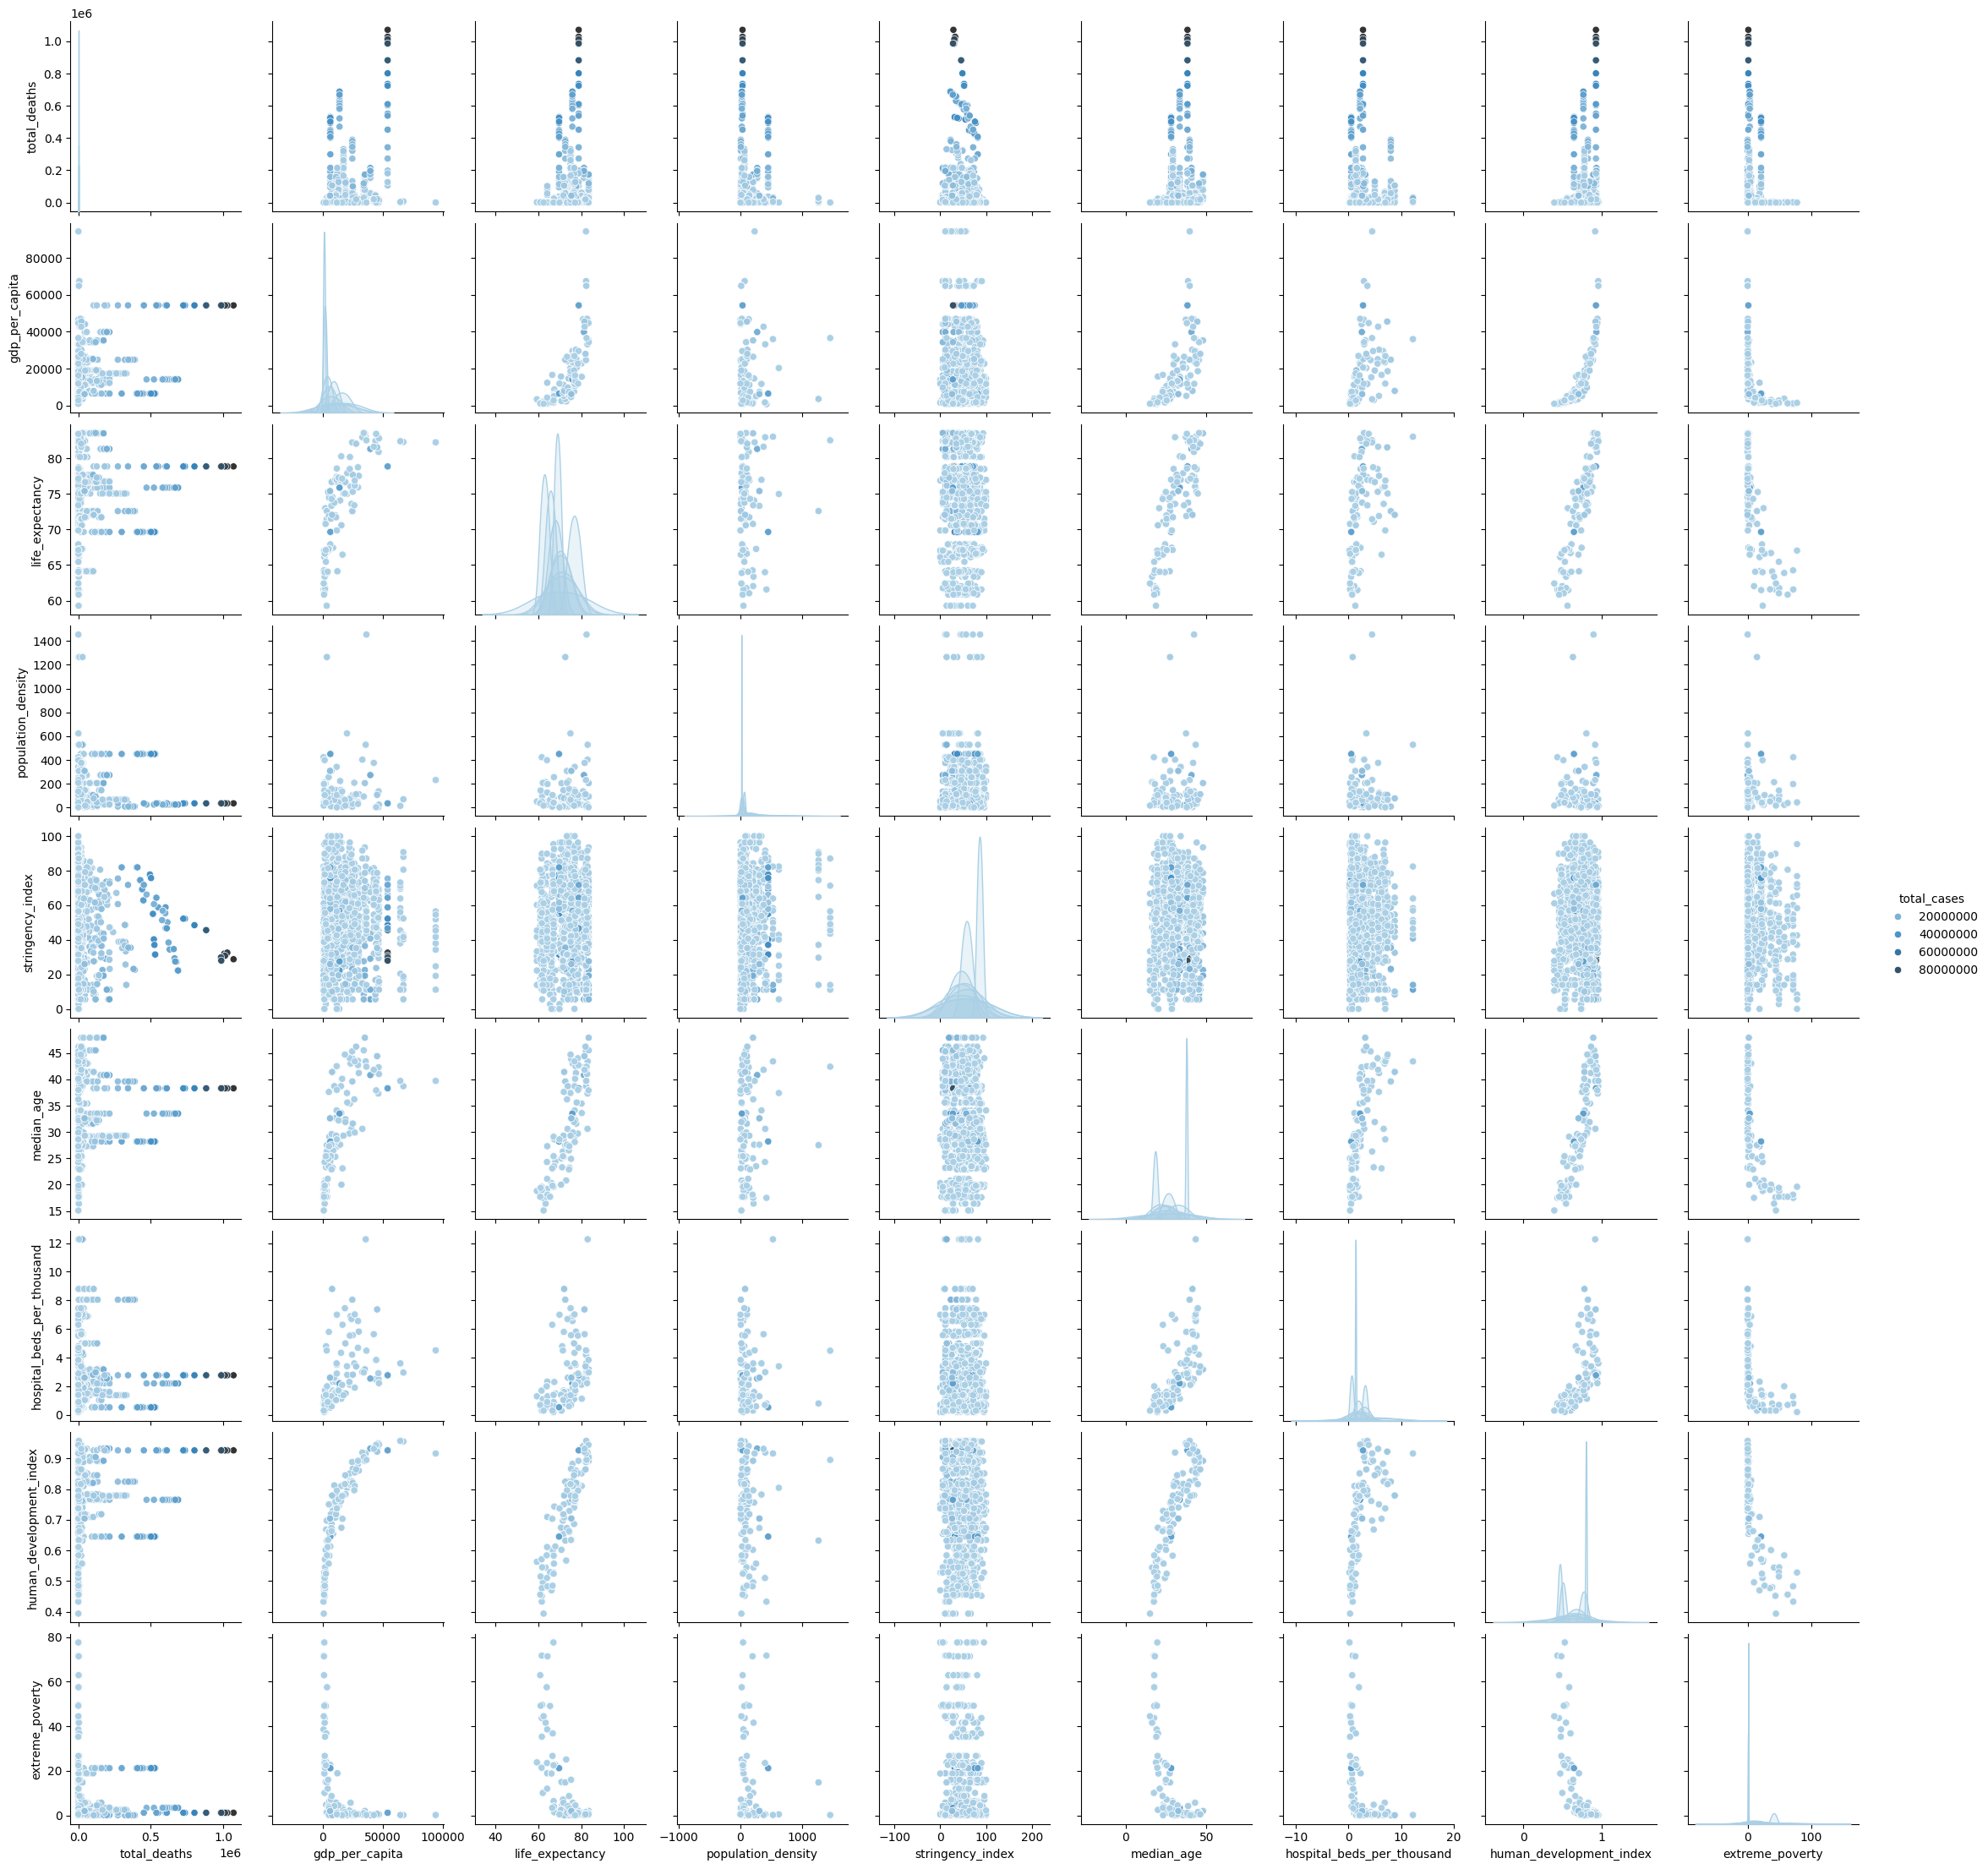

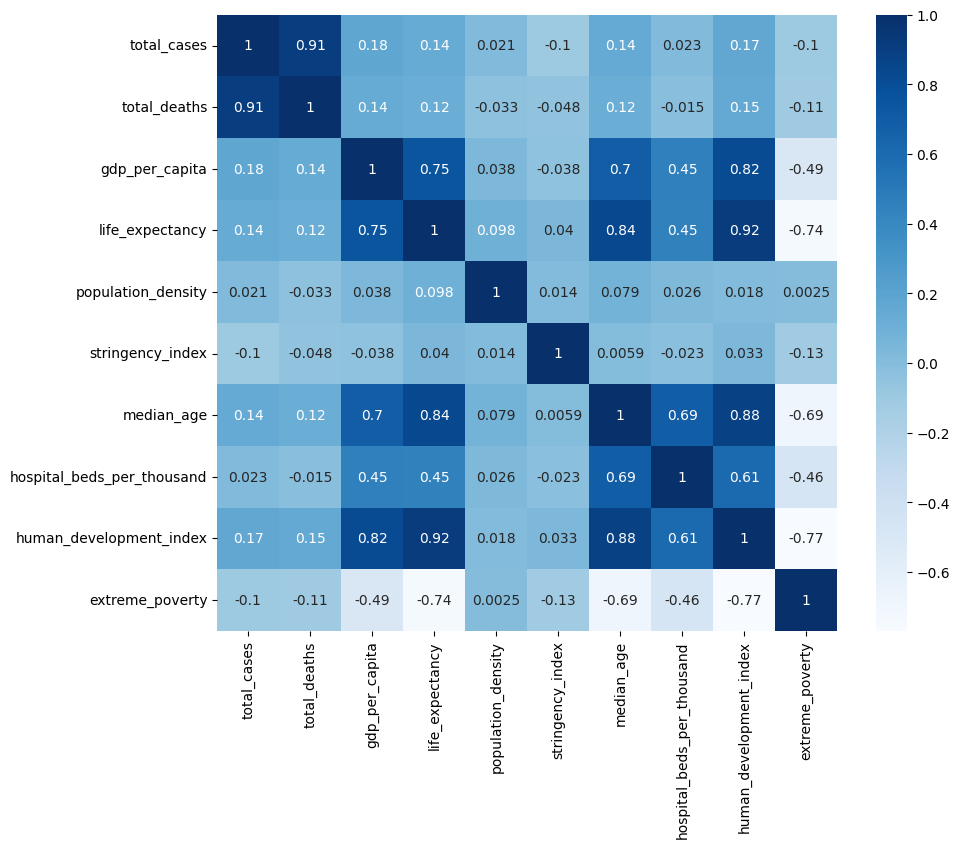

In [17]:
# test of 2k sample for visualization purposes
plot_data = sub[['total_cases', 'total_deaths', 'gdp_per_capita', 'life_expectancy',
    'population_density', 'stringency_index', 'median_age',
    'hospital_beds_per_thousand', 'human_development_index', 'extreme_poverty']].sample(2000, random_state=22)

# pairplot with 6 attributes
plt.figure(figsize=(10, 8)) 
sns.pairplot(plot_data, hue='total_cases', palette= 'Blues_d')
plt.show()

# correlation matrix
co_mtx = plot_data.corr(method='pearson')
plt.figure(figsize=(10, 8)) 
sns.heatmap(co_mtx, cmap='Blues', annot=True)

# display heatmap
plt.show()

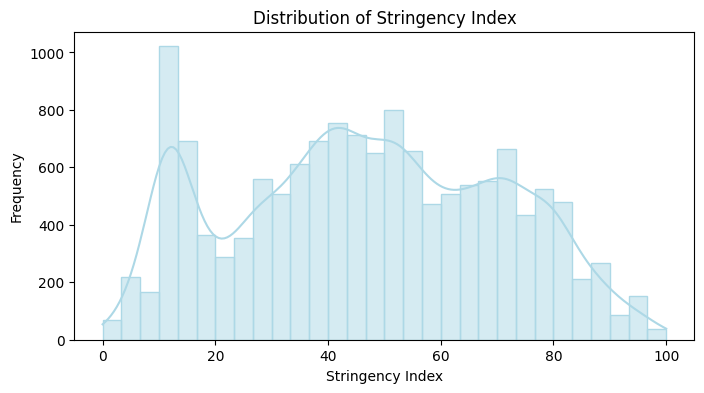

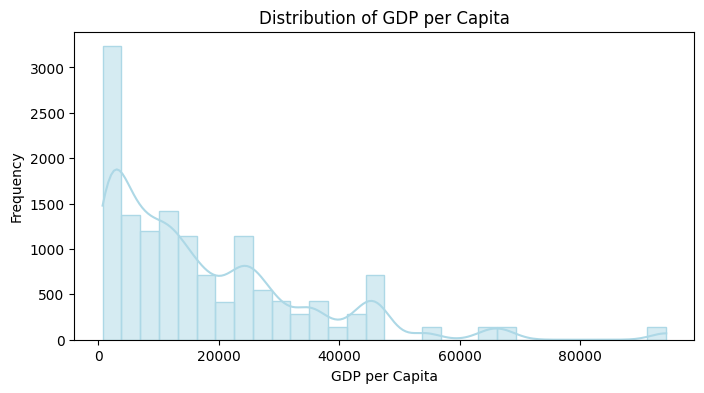

In [18]:
plt.figure(figsize=(8, 4))
sns.histplot(data=sub, x='stringency_index', bins=30, kde=True, color='lightblue', edgecolor='lightblue')
plt.title('Distribution of Stringency Index')
plt.xlabel('Stringency Index')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(data=sub, x='gdp_per_capita', bins=30, kde=True, color='lightblue', edgecolor='lightblue')
plt.title('Distribution of GDP per Capita')
plt.xlabel('GDP per Capita')
plt.ylabel('Frequency')
plt.show()


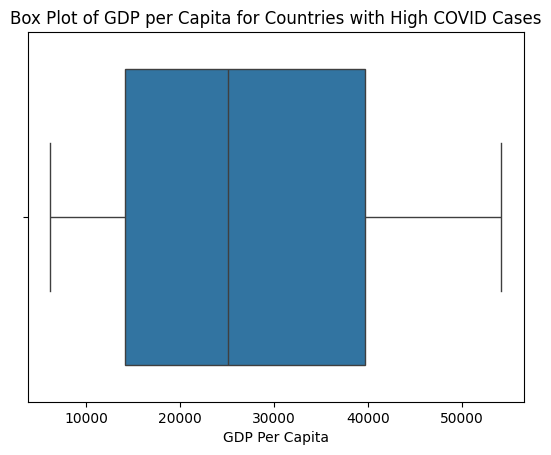

Q1: 14103.452 Q3: 39753.244 IQR: 25649.792 Min: 6171.88 Max: 54225.446 lower fence: -24371.236000000004 upper fence: 78227.932


In [19]:
# create box plot using
high_covid = sub[sub['total_cases'] > 10000000]

sns.boxplot(x=high_covid['gdp_per_capita'])
plt.title('Box Plot of GDP per Capita for Countries with High COVID Cases')
plt.xlabel('GDP Per Capita')
plt.show()

q1 = high_covid['gdp_per_capita'].quantile(0.25)
q3 = high_covid['gdp_per_capita'].quantile(0.75)
iqr = q3 - q1

# stop at whisker
lower_fence = q1 - (1.5 * iqr)
upper_fence = q3 + (1.5 * iqr)

min_val = high_covid['gdp_per_capita'][high_covid['gdp_per_capita'] > lower_fence].min()
max_val = high_covid['gdp_per_capita'][high_covid['gdp_per_capita'] < upper_fence].max()

print('Q1:', q1, 'Q3:', q3, 'IQR:', iqr,'Min:', f"{min_val:.2f}" , 'Max:', max_val, 'lower fence:', lower_fence, 'upper fence:', upper_fence )


Using the information presented in the box plot we can infer that the middle 50% of the countries in the box plot have GDP between 15469$ and 39002$, it shows a big differences between wealth. The minimun value is 6171$ and the max is 54225; which both falls inside the whiskers limit, therefore here we have no outliers because of the restriction 'df['total_cases'] > 10000000'.

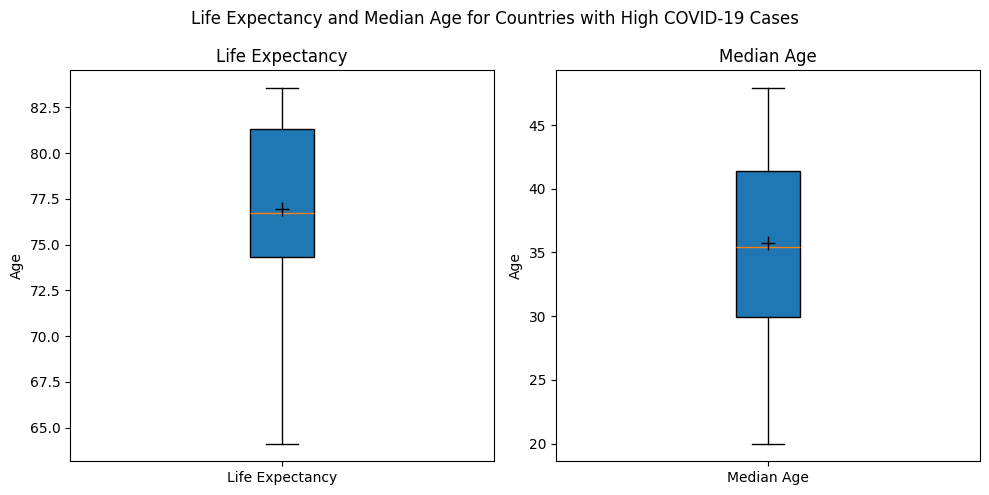

In [20]:
import matplotlib.pyplot as plt

# Filter and clean
high_cases = sub[sub['total_cases'] > 1000000]
high_cases = high_cases.dropna(subset=['life_expectancy', 'median_age'])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Boxplot for Human Development Index
axes[0].boxplot(high_cases['life_expectancy'], patch_artist=True,
                showmeans = True,
                meanprops={"marker": "+",
                       "markeredgecolor": "black",
                       "markersize": "10"})
axes[0].set_title('Life Expectancy')
axes[0].set_ylabel('Age')
axes[0].set_xticks([1])
axes[0].set_xticklabels(['Life Expectancy'])

# Boxplot for Median Age
axes[1].boxplot(high_cases['median_age'], patch_artist=True,
                showmeans = True,
                meanprops={"marker": "+",
                       "markeredgecolor": "black",
                       "markersize": "10"})
axes[1].set_title('Median Age')
axes[1].set_ylabel('Age')
axes[1].set_xticks([1])
axes[1].set_xticklabels(['Median Age'])

plt.suptitle('Life Expectancy and Median Age for Countries with High COVID-19 Cases')
plt.tight_layout()
plt.show()


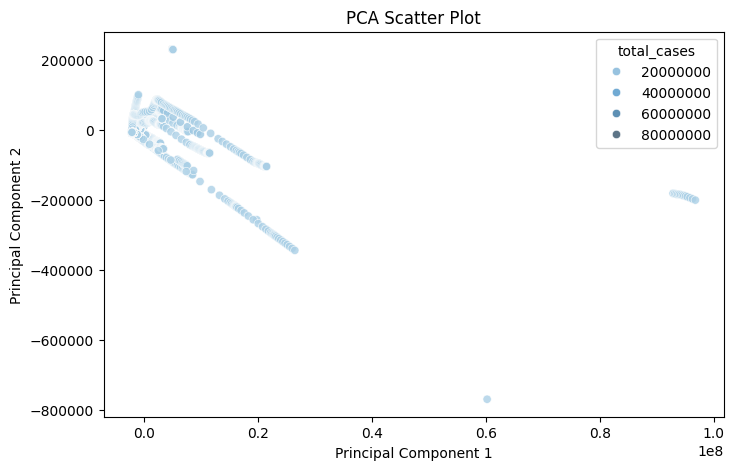

Explained variance ratio: [9.99958470e-01 3.63586119e-05]


In [ ]:
categorical_features = ['location', 'continent', 'date']

x = sub[categorical_features + ['total_cases', 'total_deaths', 'gdp_per_capita', 'life_expectancy', 'population_density']]

features = sub[numerical_cols].copy()

mask_nonzero = (features > 0).all(axis=1) # true only if every column > 0
features = features[mask_nonzero].dropna()
pca = PCA(n_components = 2)

principalComponents = pca.fit_transform(features)

principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['principal component 1', 'principal component 2'])

fig = plt.figure(figsize = (8,5))

sns.scatterplot(x=principalDf['principal component 1'], 
                y=principalDf['principal component 2'], 
                alpha=0.8, hue = sub['total_cases'], palette = 'Blues_d')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot')
plt.show()
print("Explained variance ratio:", pca.explained_variance_ratio_)


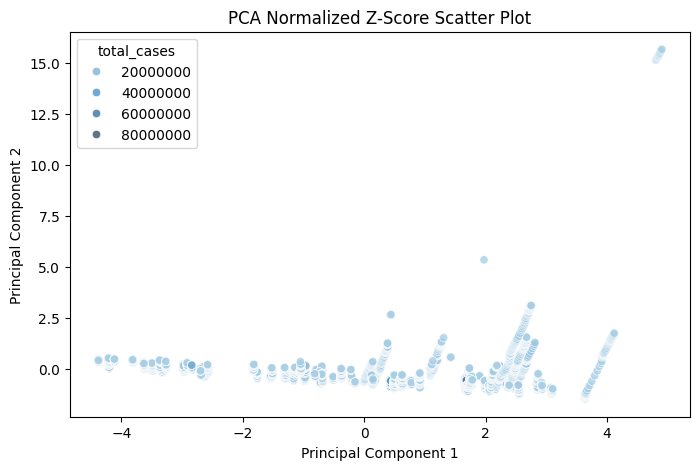

Explained variance ratio: [0.45198264 0.18704657]


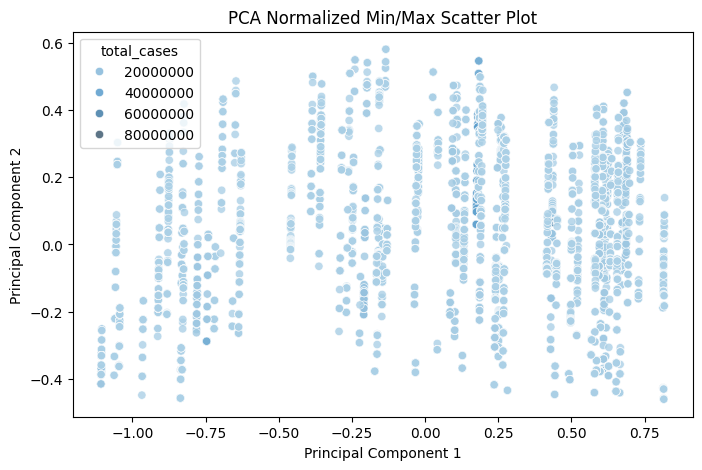

Explained variance ratio: [0.6185513  0.13481951]


In [22]:
# z-score and min/max norm
def data_norm(x, norm = "z_score"):
    eps = np.finfo(float).eps
    if norm == "z_score":
        x_norm = x - np.expand_dims(x.mean(0), axis=0)
        x_norm = x_norm / (np.expand_dims(x.std(0), axis=0) + eps)
    else:
        x_norm = x - np.expand_dims(x.min(0), axis=0)
        x_norm = x_norm / (np.expand_dims((x.max(0) - x.min(0)), axis=0) + eps)
    
    return x_norm


x_zscore = data_norm(features.values, "z_score")

x_minmax = data_norm(features.values, "min_max")


principalComponents = pca.fit_transform(x_zscore)

principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['principal component 1', 'principal component 2'])

fig = plt.figure(figsize = (8,5))

sns.scatterplot(x=principalDf['principal component 1'], 
                y=principalDf['principal component 2'], 
                alpha=0.8, hue = sub['total_cases'], palette = 'Blues_d')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Normalized Z-Score Scatter Plot')
plt.show()
print("Explained variance ratio:", pca.explained_variance_ratio_)


principalComponents = pca.fit_transform(x_minmax)

principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['principal component 1', 'principal component 2'])

fig = plt.figure(figsize = (8,5))

sns.scatterplot(x=principalDf['principal component 1'], 
                y=principalDf['principal component 2'], 
                alpha=0.8, hue = sub['total_cases'], palette = 'Blues_d')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Normalized Min/Max Scatter Plot')
plt.show()
print("Explained variance ratio:", pca.explained_variance_ratio_)



# Task 2: Classification

We’ll create a new column called risk_level with 3 classes: Low Risk (label 0), Medium Risk (label 1), High Risk (label 2)

We will base it mainly on total_cases, because it directly measures COVID-19 spread, and was one of your EDA focus points.

We’ll use a percentile approach, meaning: low(0-33%): 0, medium(34-66%): 1, high(67-100%): 2.

Plan to proceed:

1. Load your final preprocessed dataset (from finalCode output).
2. Verify: Are the 10 variables normalized? (if not, normalize them). (already Jess did)
3. Create a Risk Category:
- Based on total_cases and/or total_deaths, maybe influenced by population_density and others.
- Example rule idea (we'll refine):
- Low Risk: total_cases < 1,000
- Medium Risk: 1,000 <= total_cases < 50,000
- High Risk: total_cases >= 50,000
- We might improve this by looking at percentiles (25th, 50th, 75th).

4. Train Models:
- Decision Tree Classifier (first).
- Random Forest Classifier (second).

5. Evaluate models using:
- Accuracy
- Precision
- Recall
- Stratified K-Fold Cross Validation.

6. Conclusion: Which model predicts better? Use feature importance if needed

In [23]:
# Create Risk Categories based on total_cases
# First, define thresholds
low_thresh = sub_scaled['total_cases'].quantile(0.33)
high_thresh = sub_scaled['total_cases'].quantile(0.66)

print(f"Low threshold: {low_thresh:.2f}")
print(f"High threshold: {high_thresh:.2f}")

# Create the risk_level column
def assign_risk(total_cases):
    if total_cases <= low_thresh:
        return 0  # Low Risk
    elif total_cases <= high_thresh:
        return 1  # Medium Risk
    else:
        return 2  # High Risk

# Apply function to create labels
sub_scaled['risk_level'] = sub_scaled['total_cases'].apply(assign_risk)

# Check result
print(sub_scaled['risk_level'].value_counts())
print(sub_scaled[['total_cases', 'risk_level']].head())


Low threshold: -0.29
High threshold: -0.21
risk_level
2    4773
0    4633
1    4632
Name: count, dtype: int64
   total_cases  risk_level
0    -0.297351           0
1    -0.297336           0
2    -0.297319           0
3    -0.297300           0
4    -0.297286           0


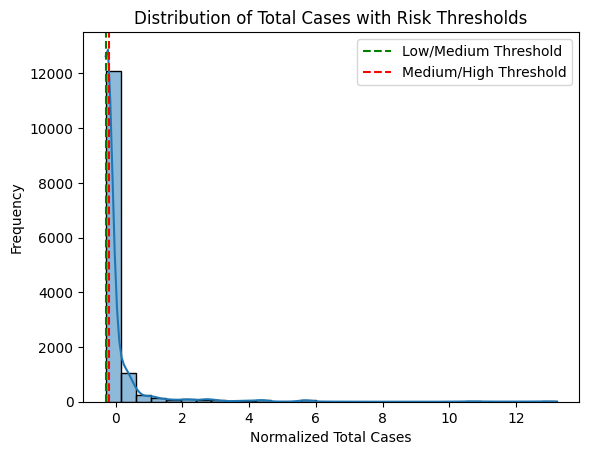

In [24]:
sns.histplot(sub_scaled['total_cases'], bins=30, kde=True)
plt.axvline(low_thresh, color='green', linestyle='--', label='Low/Medium Threshold')
plt.axvline(high_thresh, color='red', linestyle='--', label='Medium/High Threshold')
plt.title('Distribution of Total Cases with Risk Thresholds')
plt.xlabel('Normalized Total Cases')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [27]:
# Prepare X and y 
X = sub_scaled.drop(columns=['risk_level', 'total_cases'])  # features only
y = sub_scaled['risk_level']  # target is risk_level
# Split 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=22, stratify=y)

print(f"Training instances: {X_train.shape[0]}, Testing instances: {X_test.shape[0]}")

Training instances: 11230, Testing instances: 2808


In [ ]:
# Decision Tree
# Initialize and train
dtree = DecisionTreeClassifier(random_state=22)
dtree.fit(X_train, y_train)

# Predict
y_pred_tree = dtree.predict(X_test)

# Evaluate
print("Decision Tree Classifier:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_tree):.4f}")
print(f"Precision (macro): {precision_score(y_test, y_pred_tree, average='macro'):.4f}")
print(f"Recall (macro): {recall_score(y_test, y_pred_tree, average='macro'):.4f}")

ValueError: could not convert string to float: 'Ethiopia'

In [ ]:
# Random Forest
# Initialize and train
rforest = RandomForestClassifier(n_estimators=100, random_state=22)
rforest.fit(X_train, y_train)

# Predict
y_pred_forest = rforest.predict(X_test)

# Evaluate
print("\nRandom Forest Classifier:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_forest):.4f}")
print(f"Precision (macro): {precision_score(y_test, y_pred_forest, average='macro'):.4f}")
print(f"Recall (macro): {recall_score(y_test, y_pred_forest, average='macro'):.4f}")


Random Forest Classifier:
Accuracy: 0.9993
Precision (macro): 0.9993
Recall (macro): 0.9993


In [ ]:
# 5-Fold Stratified Cross Validation 
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=22)

# Define scorers
accuracy = make_scorer(accuracy_score)
precision = make_scorer(precision_score, average='macro')
recall = make_scorer(recall_score, average='macro')

# Cross-Validation for Decision Tree 

print("\nCross-Validation Results: Decision Tree Classifier")

dtree_acc = cross_val_score(dtree, X, y, cv=skf, scoring=accuracy)
dtree_prec = cross_val_score(dtree, X, y, cv=skf, scoring=precision)
dtree_rec = cross_val_score(dtree, X, y, cv=skf, scoring=recall)

print(f"Mean Accuracy: {dtree_acc.mean():.4f}")
print(f"Mean Precision (macro): {dtree_prec.mean():.4f}")
print(f"Mean Recall (macro): {dtree_rec.mean():.4f}")

# --- Cross-Validation for Random Forest ---

print("\nCross-Validation Results: Random Forest Classifier")

rforest_acc = cross_val_score(rforest, X, y, cv=skf, scoring=accuracy)
rforest_prec = cross_val_score(rforest, X, y, cv=skf, scoring=precision)
rforest_rec = cross_val_score(rforest, X, y, cv=skf, scoring=recall)

print(f"Mean Accuracy: {rforest_acc.mean():.4f}")
print(f"Mean Precision (macro): {rforest_prec.mean():.4f}")
print(f"Mean Recall (macro): {rforest_rec.mean():.4f}")


Cross-Validation Results: Decision Tree Classifier
Mean Accuracy: 0.9993
Mean Precision (macro): 0.9993
Mean Recall (macro): 0.9993

Cross-Validation Results: Random Forest Classifier
Mean Accuracy: 0.9994
Mean Precision (macro): 0.9994
Mean Recall (macro): 0.9994


                      Feature  Importance
0                total_deaths    0.640447
7     human_development_index    0.064411
5                  median_age    0.056654
4            stringency_index    0.054244
1              gdp_per_capita    0.046232
2             life_expectancy    0.041169
6  hospital_beds_per_thousand    0.035300
3          population_density    0.031687
8             extreme_poverty    0.029855


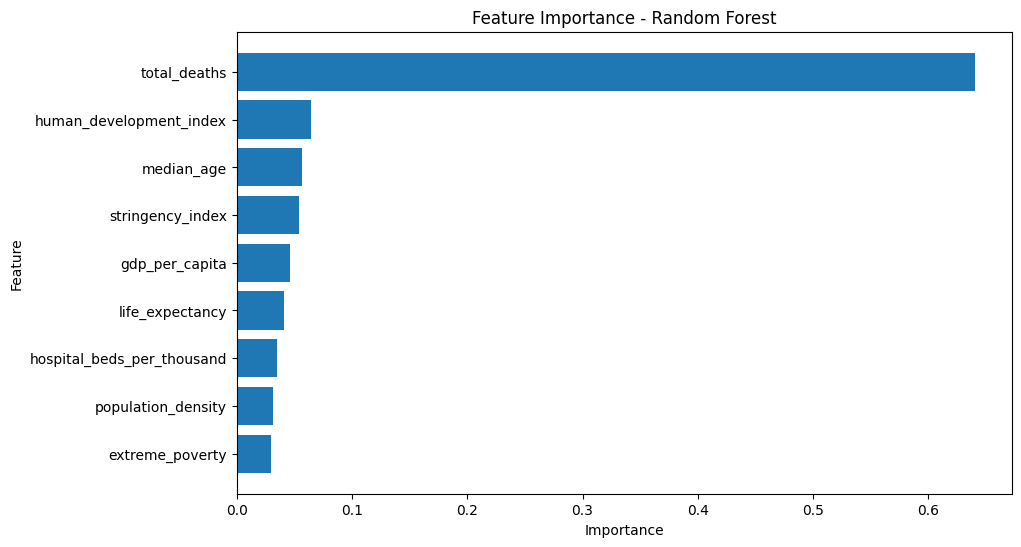

In [ ]:
# Get feature importances
importances = rforest.feature_importances_

# Create a DataFrame for easy visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print Feature Importances
print(feature_importance_df)

# --- Plot the Feature Importances ---
plt.figure(figsize=(10,6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Higher importance = stronger relationship with predicting the risk category (low, medium, high).

For example, if population_density ranks high, it means denser areas are more at risk.

Lower importance features (like extreme_poverty, if very small) could be dropped in future optimization (feature selection).

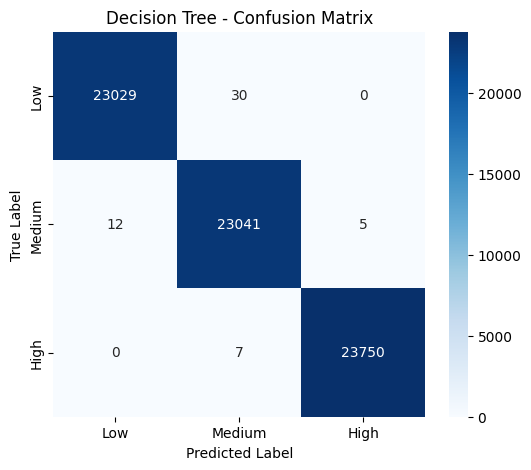

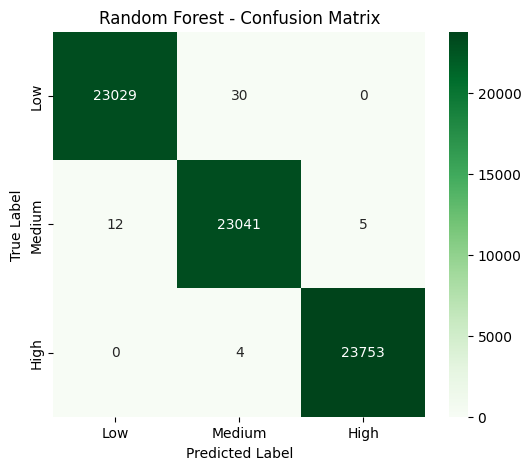

In [ ]:
# Confusion Matrix for Decision Tree 
cm_tree = confusion_matrix(y_test, y_pred_tree)

plt.figure(figsize=(6,5))
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.title('Decision Tree - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Confusion Matrix for Random Forest

cm_forest = confusion_matrix(y_test, y_pred_forest)

plt.figure(figsize=(6,5))
sns.heatmap(cm_forest, annot=True, fmt='d', cmap='Greens', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.title('Random Forest - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

    location continent       date  gdp_per_capita  stringency_index  anomaly  \
616  Algeria    Africa 2022-10-30       -0.227704         -1.981938       -1   
617  Algeria    Africa 2022-11-06       -0.227704         -1.981938       -1   
618  Algeria    Africa 2022-11-13       -0.227704         -1.981938       -1   
619  Algeria    Africa 2022-11-20       -0.227704         -1.981938       -1   
620  Algeria    Africa 2022-11-27       -0.227704         -1.981938       -1   

     is_anomaly  
616        True  
617        True  
618        True  
619        True  
620        True  


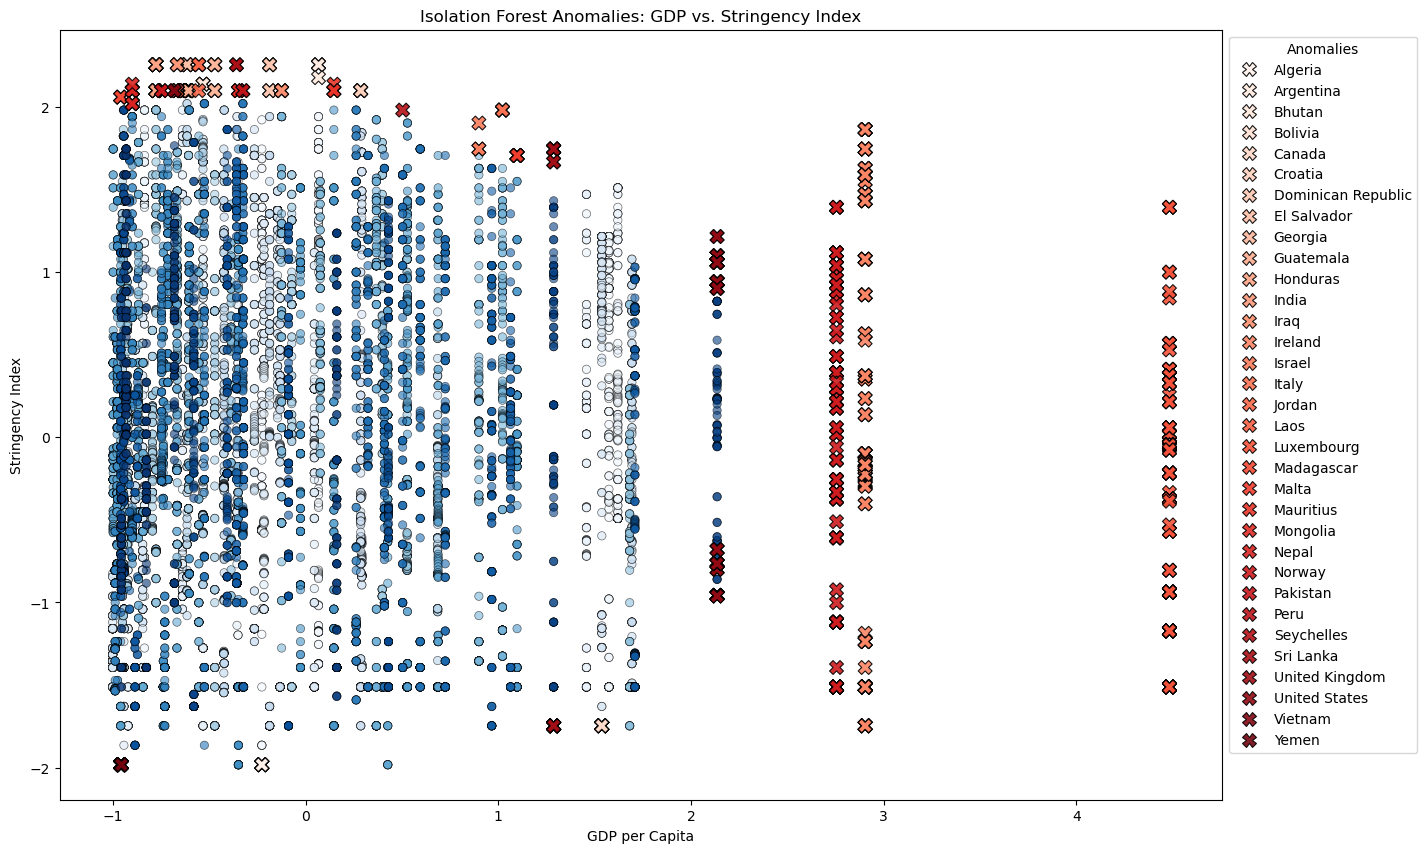

In [ ]:
features = ['gdp_per_capita', 'stringency_index']
X = sub_scaled_numerical[features]

# create isolation forest model
model = IsolationForest(n_estimators=200, contamination=0.05, random_state=0)
anomaly_labels = model.fit_predict(X)

# create results df with metadata
results = sub[['location', 'continent', 'date']].iloc[X.index].copy()
results['gdp_per_capita'] = sub_scaled_numerical['gdp_per_capita'].iloc[X.index].values
results['stringency_index'] = sub_scaled_numerical['stringency_index'].iloc[X.index].values
results['anomaly'] = anomaly_labels
results['is_anomaly'] = results['anomaly'] == -1
print(results[results['is_anomaly']].head())

# create scatter plot: points will be colored by country using 'hue' and assigned color palette
plt.figure(figsize=(15, 10))

sns.scatterplot(
    data=results[results['is_anomaly'] == False],
    x='gdp_per_capita',
    y='stringency_index',
    hue='location',
    palette='Blues',
    alpha=0.6,
    edgecolor='k',
    legend=False, 
    marker='o'
)

# anomaly points (colored by country and marked with 'x')
sns.scatterplot(
    data=results[results['is_anomaly'] == True],
    x='gdp_per_capita',
    y='stringency_index',
    hue='location',
    palette='Reds',
    alpha=0.9,
    edgecolor='k',
    marker='X',
    s=100
)

plt.title("Isolation Forest Anomalies: GDP vs. Stringency Index")
plt.legend(title="Anomalies", bbox_to_anchor=(1, 1), loc='upper left')
plt.xlabel("GDP per Capita")
plt.ylabel("Stringency Index")
plt.show()

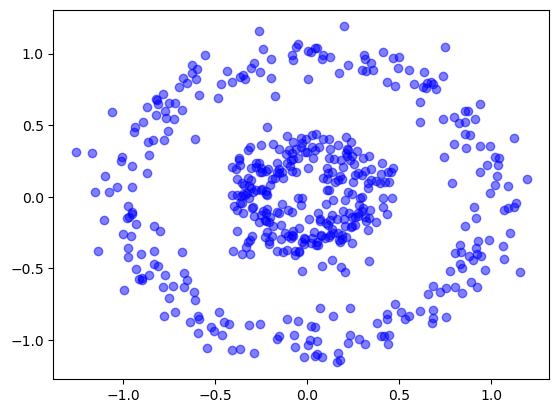

In [ ]:
X, y = make_circles(n_samples=500, noise=0.1, factor=0.3, random_state=0)
plt.scatter(X[:, 0], X[:, 1], c='blue', alpha=0.5)

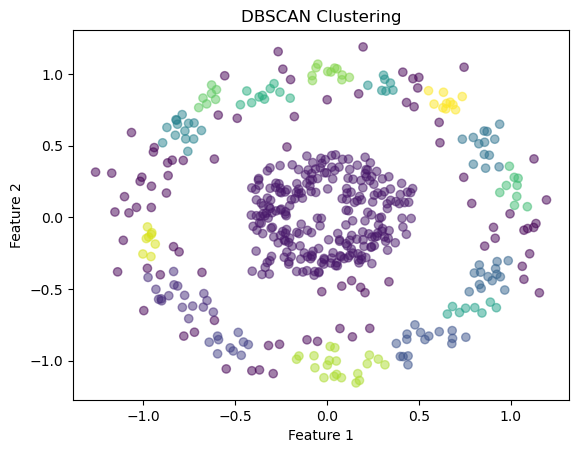

In [ ]:
dbscan = DBSCAN(eps=0.1, min_samples=5)
labels = dbscan.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.title("DBSCAN Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()